# Anime Recommendations Database
## 애니매이션 추천 시스템

https://www.kaggle.com/CooperUnion/anime-recommendations-database

Recommendation으로 케글에 검색했을떄 가장 상단에 나오는 데이터셋을 사용 함.  
이 데이터셋을 사용하여 유저가 특정 애니메이션을 보고 생각하는 rating을 예측 함.  
즉, rating을 예측하는 분류 문제임.  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
anime = pd.read_csv("./data/anime.csv")
rating = pd.read_csv("./data/rating.csv")

In [3]:
rating_count = rating.groupby("user_id").count()
#rating_count = rating.groupby("user_id").indices
rating_count

,anime_id,rating
user_id,,
1,153,153
2,3,3
3,94,94
4,52,52
5,467,467
...,...,...
73512,13,13
73513,33,33
73514,1,1


## 전처리
1. 평가한 애니매이션 숫자가 충분하지 않을 경우 데이터 셋에서 제외 함.  
2. genre가 nan일경우 Unknown으로 수정
3. 각 애니메이션마다 가지고 있는 genre의 숫자가 다르기 때문에 N개의 장르가 있을 때, 전체 장르에서 가장 많이 나오는 장르 순으로 N개 중 3개를 선택 함.
4. 선택 한 장르를 label encoding 함. One hot encoding을 사용하는것이 향후 성능 개선에 더 좋은 방향이라고 생각되지만, 일단 컨셉 증명을 위해 label encoding을 사용.

In [4]:
sufficient_id = rating_count.loc[rating_count["anime_id"] > 10].index
sufficient_id.shape

(60900,)

In [5]:
sufficient_rating = rating[rating["user_id"].isin(list(sufficient_id))].reset_index(drop=True)
sufficient_rating

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7755191,73515,13659,8
7755192,73515,14345,7
7755193,73515,16512,7
7755194,73515,17187,9


In [6]:
anime = anime.loc[anime["rating"].isna() == False]
anime.isna().sum()

anime_id     0
name         0
genre       47
type         0
episodes     0
rating       0
members      0
dtype: int64

In [7]:
anime.loc[anime["genre"].isna(), "genre"] = "Unknown"
anime["genre"].isna().sum()

0

In [8]:
df = pd.merge(sufficient_rating, anime, left_on="anime_id", right_on="anime_id")
df.sort_values(by=["user_id"], inplace=True)
df.reset_index(drop=True, inplace=True);

In [9]:
df.rename(columns={"rating_x":"user_rating", "rating_y":"avg_rating"}, inplace=True)
df.columns

Index(['user_id', 'anime_id', 'user_rating', 'name', 'genre', 'type',
       'episodes', 'avg_rating', 'members'],
      dtype='object')

In [10]:
genre_list = []
for genre in anime["genre"]:
    genre_list += genre.split(", ")

genre_in_data = set(genre_list)

In [11]:
max_genre=-1
max_genre_list = 0
genre_length = []
for genre in anime["genre"]:
    candidate = len(genre.split(", "))
    genre_length.append(candidate)
    if candidate > max_genre:
        max_genre = candidate
        max_genre_list = genre.split(", ")

print(np.array(genre_length).mean())
max_genre_list
    


2.9544098143236073


['Adventure',
 'Comedy',
 'Drama',
 'Fantasy',
 'Game',
 'Magic',
 'Martial Arts',
 'Mecha',
 'School',
 'Sci-Fi',
 'Slice of Life',
 'Super Power',
 'Supernatural']

In [12]:
top_genre = {}
for genre in genre_list:
    if genre in top_genre:
        top_genre[genre] += 1
    else:
        top_genre[genre] = 1

top_genre = dict(sorted(top_genre.items(), key=lambda item: item[1], reverse=True))
top_genre


{'Comedy': 4575,
 'Action': 2768,
 'Adventure': 2316,
 'Fantasy': 2242,
 'Sci-Fi': 2036,
 'Drama': 1977,
 'Shounen': 1684,
 'Kids': 1598,
 'Romance': 1437,
 'Slice of Life': 1204,
 'School': 1176,
 'Hentai': 1133,
 'Supernatural': 1001,
 'Mecha': 929,
 'Music': 842,
 'Historical': 798,
 'Magic': 747,
 'Ecchi': 628,
 'Shoujo': 594,
 'Sports': 533,
 'Seinen': 532,
 'Mystery': 485,
 'Super Power': 451,
 'Military': 416,
 'Parody': 403,
 'Space': 377,
 'Horror': 362,
 'Harem': 313,
 'Demons': 287,
 'Martial Arts': 264,
 'Dementia': 238,
 'Psychological': 226,
 'Police': 195,
 'Game': 177,
 'Samurai': 146,
 'Vampire': 100,
 'Thriller': 86,
 'Cars': 72,
 'Shounen Ai': 62,
 'Shoujo Ai': 54,
 'Josei': 52,
 'Unknown': 47,
 'Yuri': 41,
 'Yaoi': 38}

In [13]:
top3_genre = pd.DataFrame(columns=["genre1", "genre2", "genre3"])
top3_genre

,genre1,genre2,genre3


In [14]:
%%time
df_genre_length = len(df["genre"])
top3_list = []

for idx, genre in enumerate(df["genre"]):    
    top_list = []
    genre_list = genre.split(", ")
    
    for key, _ in top_genre.items():
        if key in genre_list:
            top_list.append(key)
        
        if len(top_list) == 3:
            break
    
    if len(top_list) == 0:
        top_list = ["None"] * 3

    if len(top_list) == 1:
        top_list += ["None"] * 2

    if len(top_list) == 2:
        top_list += ["None"]
    
    if idx % 500000 == 0:
        print(f"{idx}/{df_genre_length}")

    top3_list.append(top_list)

0/7755180
500000/7755180
1000000/7755180
1500000/7755180
2000000/7755180
2500000/7755180
3000000/7755180
3500000/7755180
4000000/7755180
4500000/7755180
5000000/7755180
5500000/7755180
6000000/7755180
6500000/7755180
7000000/7755180
7500000/7755180
Wall time: 39.5 s


In [16]:
%%time
top3_genre = pd.DataFrame(np.array(top3_list), columns=["genre1", "genre2", "genre3"])
top3_genre.head()

Wall time: 18.4 s


,genre1,genre2,genre3
0,Comedy,Action,Shounen
1,Comedy,Romance,School
2,Action,Fantasy,Drama
3,Action,Romance,School
4,Comedy,Sci-Fi,Romance


In [17]:
genre_in_data.add("None")

In [18]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(list(genre_in_data))

LabelEncoder()

In [19]:
encoded_top3_genre = top3_genre.apply(lambda genre: le.transform(genre))

In [20]:
df = pd.concat([df, encoded_top3_genre], axis=1)
df

,user_id,anime_id,user_rating,name,genre,type,episodes,avg_rating,members,genre1,genre2,genre3
0,1,20,-1,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297,3,0,33
1,1,12729,-1,High School DxD OVA,"Comedy, Demons, Ecchi, Romance, School",OVA,2,7.47,91154,3,26,28
2,1,25283,-1,Kuusen Madoushi Kouhosei no Kyoukan,"Action, Drama, Fantasy, Magic, School",TV,12,6.57,81870,0,8,6
3,1,25397,-1,Absolute Duo,"Action, Ecchi, Harem, Romance, School, Superna...",TV,12,6.78,168811,0,26,28
4,1,19163,-1,Date A Live II,"Comedy, Harem, Mecha, Romance, School, Sci-Fi",TV,10,7.50,186187,3,29,26
...,...,...,...,...,...,...,...,...,...,...,...,...
7755175,73515,3588,9,Soul Eater,"Action, Adventure, Comedy, Fantasy, Shounen, S...",TV,51,8.08,580184,3,0,1
7755176,73515,460,-1,One Piece Movie 2: Nejimaki-jima no Daibouken,"Action, Adventure, Comedy, Fantasy, Shounen, S...",Movie,1,7.33,37792,3,0,1
7755177,73515,1454,9,Kemonozume,"Action, Demons, Horror, Romance, Supernatural",TV,13,7.59,33086,0,26,39
7755178,73515,3594,9,Tears to Tiara,"Action, Adventure, Fantasy, Magic",TV,26,7.31,50455,0,1,8


In [21]:
df["type"] = le.fit_transform(df[["type"]])

In [22]:
temp_df = df.drop(columns=["name", "genre", "type", "episodes"], axis=1)
temp_df.head()

,user_id,anime_id,user_rating,avg_rating,members,genre1,genre2,genre3
0,1,20,-1,7.81,683297,3,0,33
1,1,12729,-1,7.47,91154,3,26,28
2,1,25283,-1,6.57,81870,0,8,6
3,1,25397,-1,6.78,168811,0,26,28
4,1,19163,-1,7.50,186187,3,29,26


In [23]:
%%time
from sklearn.model_selection import train_test_split
temp_df = temp_df.apply(lambda col: pd.to_numeric(col))
target = temp_df[["user_rating"]]
features = temp_df.drop(columns=["user_rating"], axis=1)
train_X, test_X, train_y, test_y = train_test_split(features, target, test_size=0.2, random_state=1)

Wall time: 4.4 s


모델로는 lightgbm의 LGBMClassifier를 사용 함.  
Baseline : avg_rating

In [24]:
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMClassifier

In [41]:
train_X.shape

(6204144, 7)

In [43]:
%%time
lgbmclassifer = LGBMClassifier(n_estimators=100, random_state=1, n_jobs=-1, num_leaves=35, max_depth=5, learning_rate=0.2)
#lgbmclassifer.fit(train_X[:1000000], train_y[:1000000])
lgbmclassifer.fit(train_X[:], train_y[:])

Wall time: 3min


LGBMClassifier(learning_rate=0.2, max_depth=5, num_leaves=35, random_state=1)

In [44]:
test_y.shape

(1551036, 1)

In [45]:
result = test_y[:]
result["Prediction"] = lgbmclassifer.predict(test_X[:])
result

,user_rating,Prediction
1515249,9,9
1541149,8,7
2960055,10,10
5365951,-1,8
3184473,6,10
...,...,...
2799432,7,-1
31762,7,8
4178274,8,-1
2814022,9,8


In [46]:
temp = pd.merge(test_X[:], anime, left_on="anime_id", right_on="anime_id")
temp["user_rating"] = result["user_rating"].reset_index(drop=True)
temp["Prediction"] = result["Prediction"].reset_index(drop=True)
temp = temp.drop(columns=["genre1", "genre2", "genre3", "members_x", "members_y"], axis=1)

In [74]:
mean_squared_error(result["user_rating"], temp["avg_rating"])

16.64929242164592

In [75]:
mean_squared_error(result["user_rating"], result["Prediction"])

22.141684654643736

MSE 상으로는 baseline이 더 높게 나옴. 하지만 baseline의 avg_rating은 float 값이고, 모델의 prediction은 int값이기 때문에 단순 MSE 값 만으로 baseline과 모델을 비교하기에는 무리가 있는 것 같음.

In [48]:
temp.head()

,user_id,anime_id,avg_rating,name,genre,type,episodes,rating,user_rating,Prediction
0,14730,2236,8.44,Toki wo Kakeru Shoujo,"Adventure, Drama, Romance, Sci-Fi",Movie,1,8.44,9,9
1,19394,2236,8.44,Toki wo Kakeru Shoujo,"Adventure, Drama, Romance, Sci-Fi",Movie,1,8.44,8,7
2,14032,2236,8.44,Toki wo Kakeru Shoujo,"Adventure, Drama, Romance, Sci-Fi",Movie,1,8.44,10,10
3,16925,2236,8.44,Toki wo Kakeru Shoujo,"Adventure, Drama, Romance, Sci-Fi",Movie,1,8.44,-1,8
4,51762,2236,8.44,Toki wo Kakeru Shoujo,"Adventure, Drama, Romance, Sci-Fi",Movie,1,8.44,6,10


In [49]:
temp.loc[temp["user_id"] == 14730]

,user_id,anime_id,avg_rating,name,genre,type,episodes,rating,user_rating,Prediction
0,14730,2236,8.44,Toki wo Kakeru Shoujo,"Adventure, Drama, Romance, Sci-Fi",Movie,1,8.44,9,9
36918,14730,20899,8.25,JoJo no Kimyou na Bouken: Stardust Crusaders,"Action, Adventure, Drama, Shounen, Supernatural",TV,24,8.25,10,10
39118,14730,10620,8.07,Mirai Nikki (TV),"Action, Mystery, Psychological, Shounen, Super...",TV,26,8.07,6,7
259433,14730,10794,7.12,IS: Infinite Stratos Encore - Koi ni Kogareru ...,"Action, Comedy, Harem, Mecha, Sci-Fi",OVA,1,7.12,7,8
279200,14730,18153,7.88,Kyoukai no Kanata,"Fantasy, Slice of Life, Supernatural",TV,12,7.88,8,8
288716,14730,14467,7.73,K,"Action, Super Power, Supernatural",TV,13,7.73,7,8
321779,14730,47,8.15,Akira,"Action, Adventure, Horror, Military, Sci-Fi, S...",Movie,1,8.15,8,8
582900,14730,28223,8.33,Death Parade,"Drama, Game, Mystery, Psychological, Thriller",TV,12,8.33,7,8
889004,14730,2001,8.78,Tengen Toppa Gurren Lagann,"Action, Adventure, Comedy, Mecha, Sci-Fi",TV,27,8.78,10,8
1001548,14730,528,7.66,Pokemon: Mewtwo no Gyakushuu,"Action, Adventure, Comedy, Drama, Fantasy, Kids",Movie,1,7.66,10,9


user_id를 기준으로 표시했을떄 user_rating과 prediction이 어느정도 유사하게 나타나는 것을 확인 할 수 있었음.  
Prediction의 값이 특정 값 이상일때 추천 하는 방식으로 추천 시스템을 구현 할 수있을것 같음.

In [76]:
from sklearn.ensemble import RandomForestClassifier

In [78]:
rf = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1, max_depth=5)

In [79]:
%%time
rf.fit(train_X[:], train_y[:])

Wall time: 4min 52s


RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=1)

In [80]:
rf_result = test_y[:]
rf_result["Prediction"] = rf.predict(test_X[:])
rf_result

,user_rating,Prediction
1515249,9,9
1541149,8,8
2960055,10,10
5365951,-1,7
3184473,6,8
...,...,...
2799432,7,-1
31762,7,8
4178274,8,-1
2814022,9,8


In [81]:
mean_squared_error(rf_result["user_rating"], rf_result["Prediction"])

23.271591375055124

boosting에서 random forest로 변경했을때 mse가 살짝 올라감.

## 모델 해석

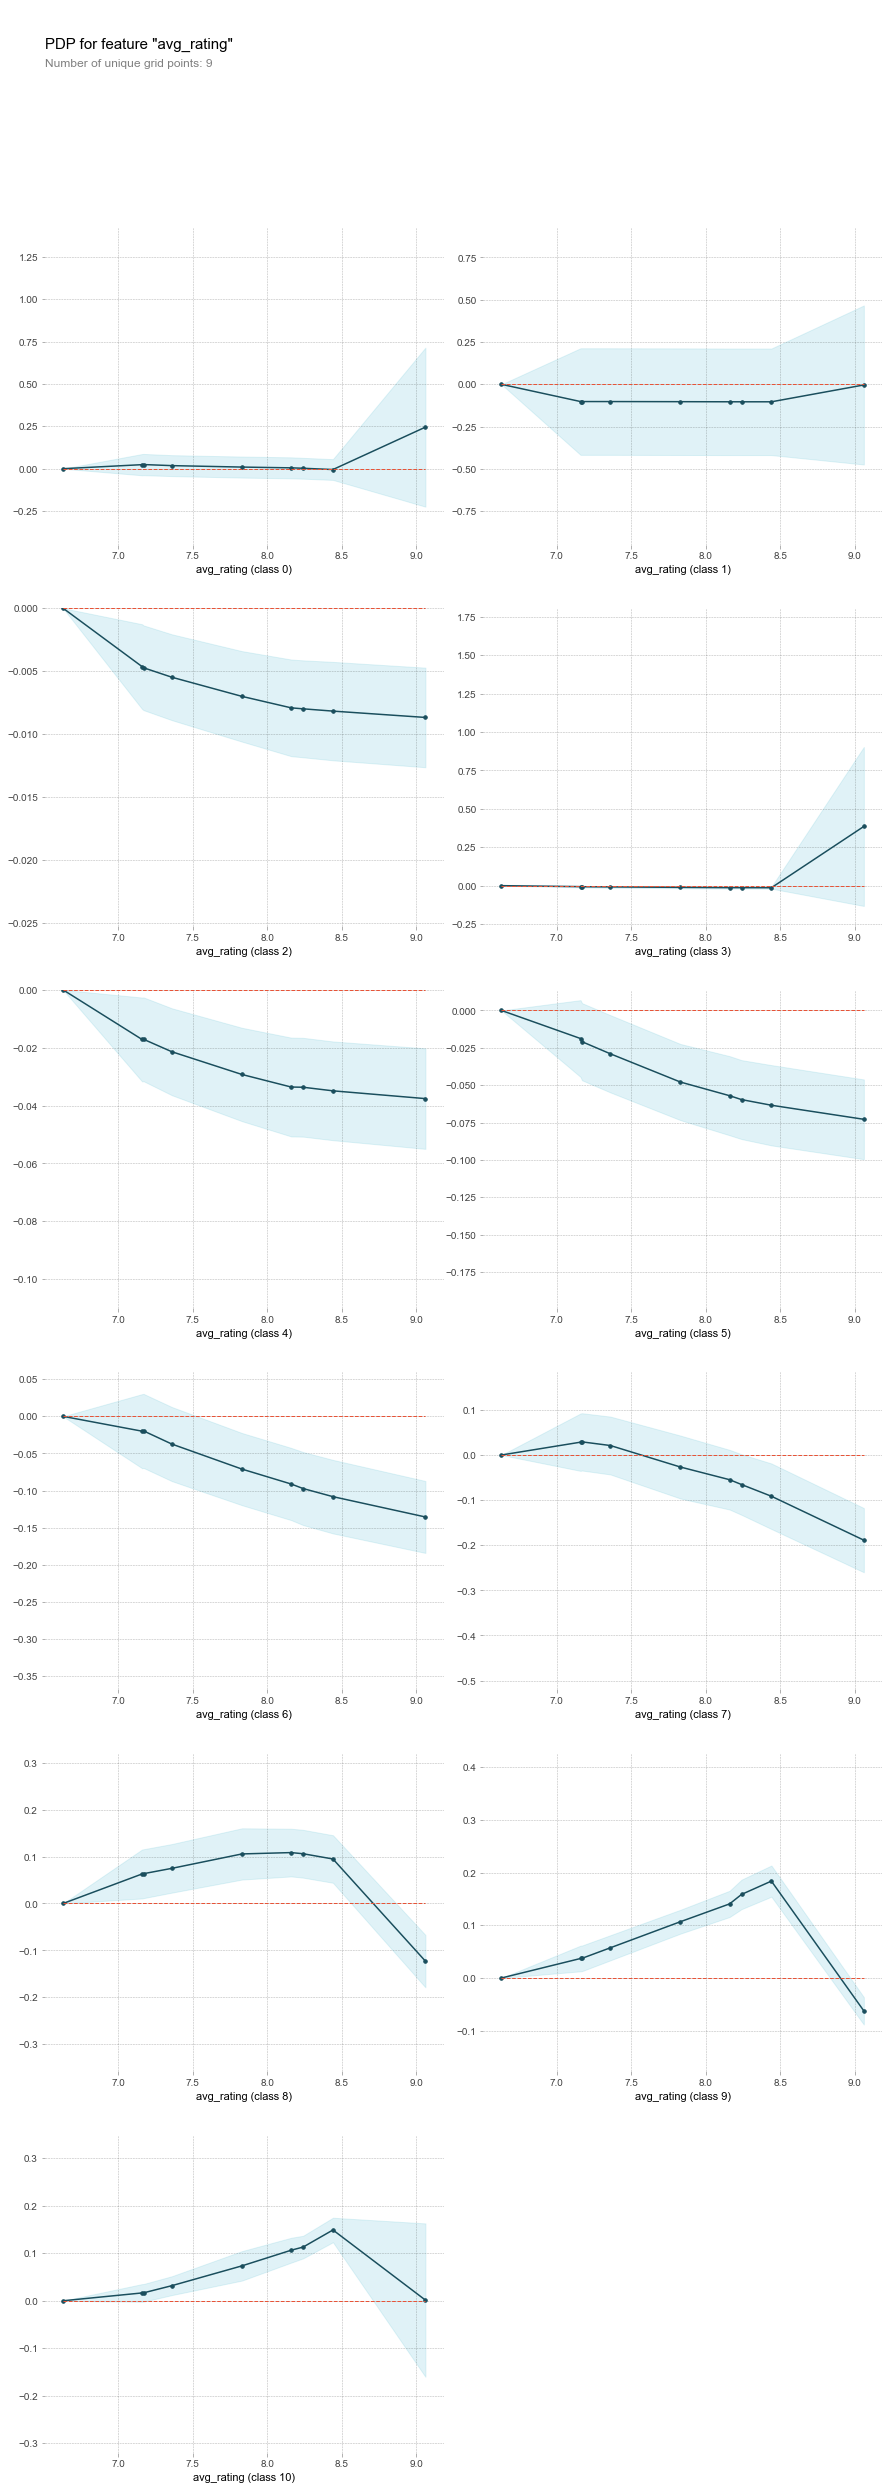

In [82]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'avg_rating'
isolated = pdp_isolate(
    model=lgbmclassifer, 
    dataset=test_X[:10], 
    model_features=test_X[:10].columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

avg_rating이 높을수록 높은 클래스 추정에 많은 영향을 줌.    
즉, avg_rating이 높을 경우 호불호가 갈리지 않아 누구나 높은 점수(class)를 주는 경향이 있어 높은 점수는 avg_rating을 이용한 추측이 쉽지만  
낮을경우 호불호가 갈리기 때문에 avg_rating이 추측에 큰 영향을 주지 못함. 

In [51]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [52]:
features = ['avg_rating', 'genre1']

interaction = pdp_interact(
    model=lgbmclassifer, 
    dataset=test_X[:100],
    model_features=test_X.columns, 
    features=features,
    num_grid_points=[10, 20]
)

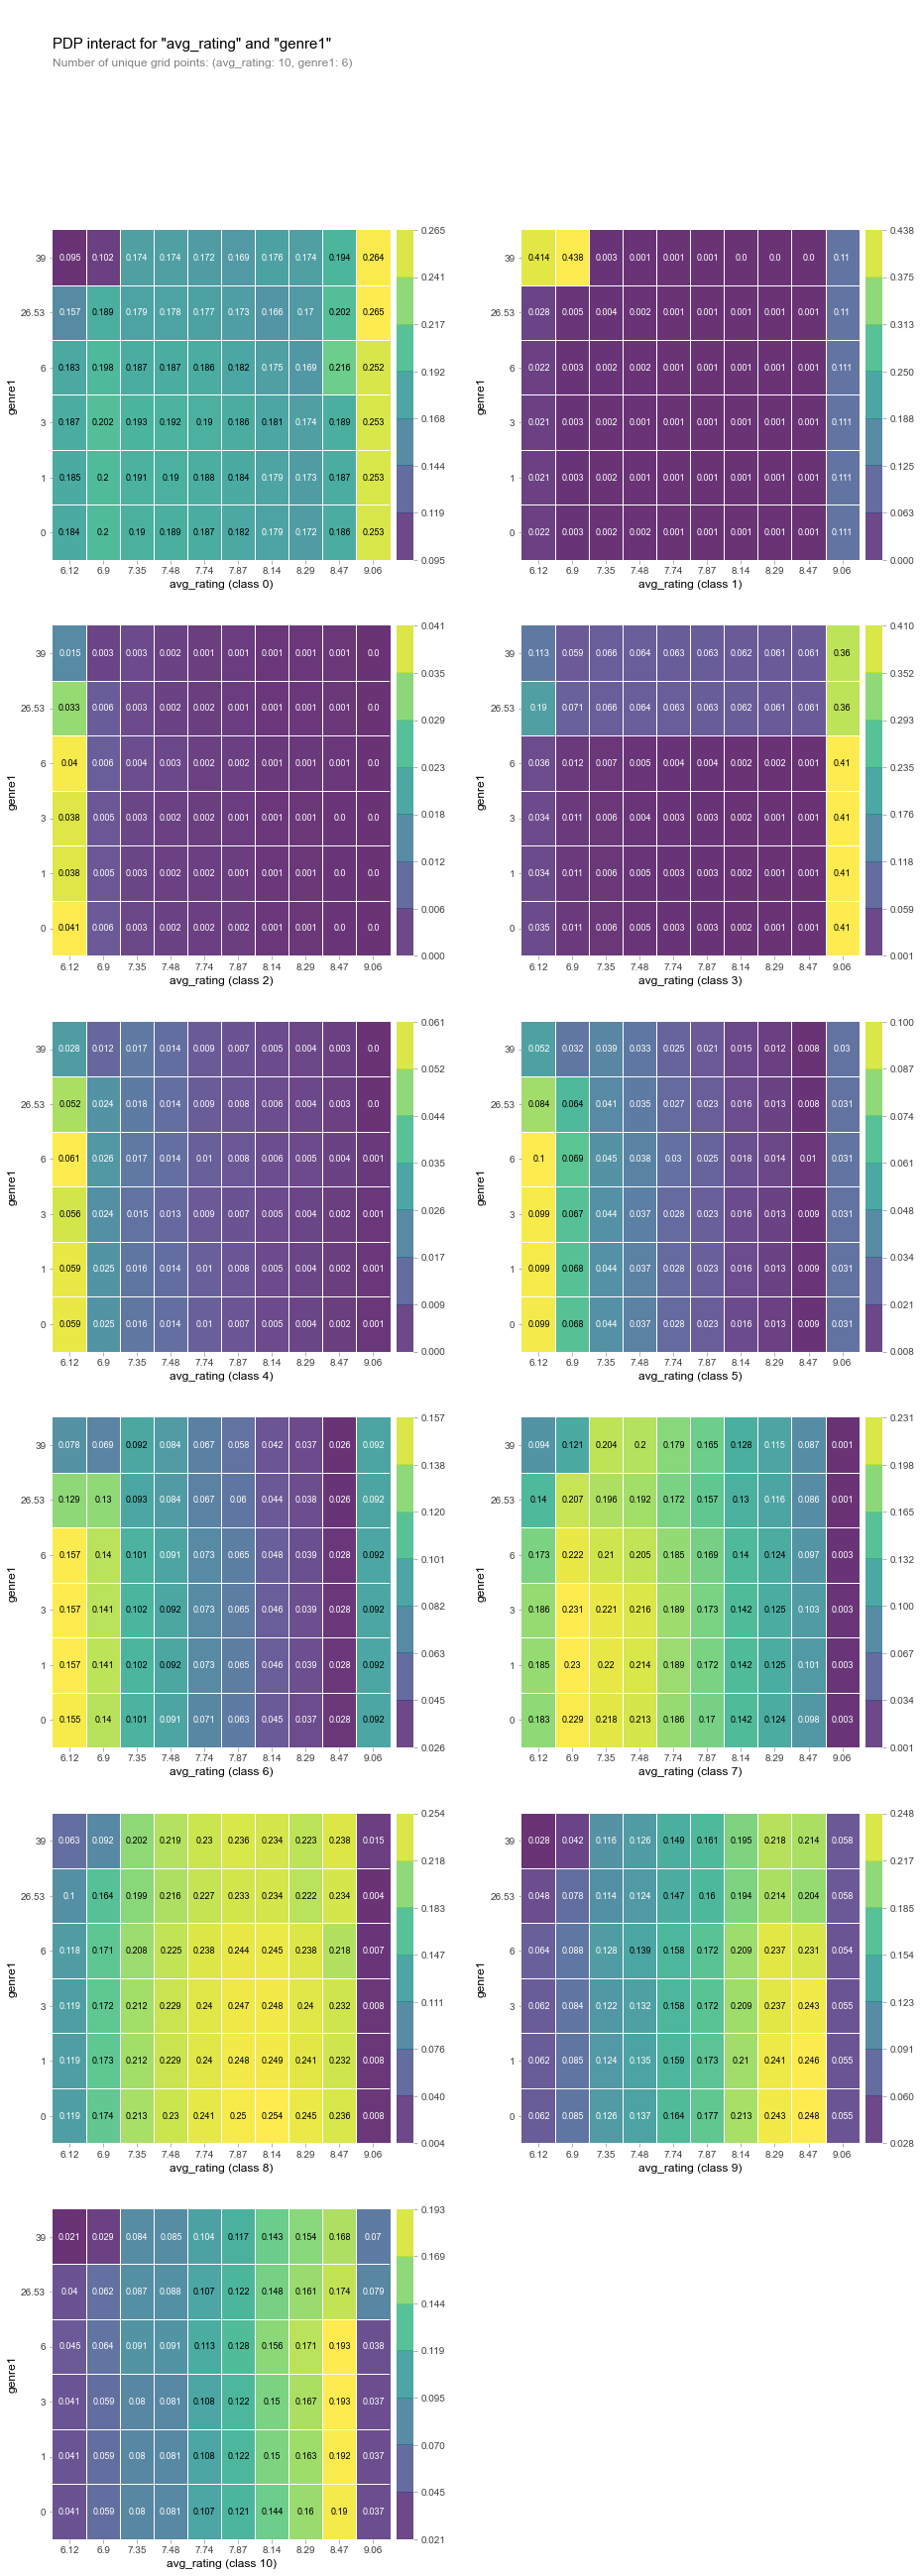

In [53]:
pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

마찬가지로 높은 점수(class) 추정에 avg_rating이 많은 영향을 주었음.  
avg_rating이 낮을경우에는 genre가 영향을 줌.  
이를 보았을때 호불호가 갈려서 avg_rating이 낮을경우 장르가 점수 추정에 영향을 많이 줌.  

### 3) SHAP 라이브러리를 사용해 최소 3개 이상 시각화를 하고 분석하세요

In [59]:
row = test_X.iloc[[0]]
row

,user_id,anime_id,avg_rating,members,genre1,genre2,genre3
1515249,14730,2236,8.44,289206,1,29,6


In [60]:
test_y.iloc[[0]]

,user_rating
1515249,9


In [61]:
lgbmclassifer.predict(row)

array([9], dtype=int64)

In [62]:
lgbmclassifer.predict_proba(row)

array([[0.16054079, 0.00052436, 0.00056184, 0.00101224, 0.00312908,
        0.00956776, 0.02755341, 0.10322401, 0.23091521, 0.2610157 ,
        0.20195559]])

In [63]:
### 이곳에서 과제를 진행해 주세요 ### 
import shap


explainer = shap.TreeExplainer(lgbmclassifer)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[9], 
    shap_values=shap_values[9],
    features=row
)
# 클래스에 해당하는 shap_value가 base value에 가깝다?

Class 9(f(x))의 값을 얻는데 members, user_id, avg_rating, genre2가 높은 영향을 주었음.  
즉, genre2에 대해서 얼마나 학습이 잘되느냐에 따라서 정확도가 갈릴 것 같음. 

In [64]:
shap_values = explainer.shap_values(test_X.iloc[:10])
shap.force_plot(explainer.expected_value[9], shap_values[9], test_X.iloc[:10])

입력값이 user_id=1.332e+4, avg_rating=8.24, genre2=12에 가까울수록 Class 9(f(x))의 값을 얻을 확률이 높음.  
user_id가 높은 중요도를 보이기 때문에 어느정도 개인형 맞춤 추천이 가능할 것이라고 생각 됨.  

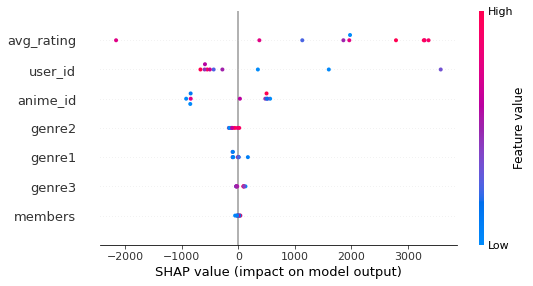

In [65]:
shap_values = explainer.shap_values(test_X.iloc[:10])
shap.summary_plot(shap_values[9], train_X.iloc[:10])

위에서 예상했던대로 genre2, avg_rating, user_id가 높은 영향(+ 또는 -)을 줌. 